당신은 기계 이상유무 판단이라는 기업 과제를 맡은 머신러닝 엔지니어입니다
train_data: 학습용 데이터로 모두 정상 case로 이루어진 데이터입니다.
test_data: 평가용 데이터로 정상 case와 이상 case가 함께 포함되어 있는 데이터로, 예측 대상에 해당됩니다.
위의 2개의 데이터를 이용하여 기계 이상유무를 판단하고 정상은 0으로 이상은 1로 판단하는 비지도학습 알고리즘 코드를 만들어주세요
단, lof, kmeans, IsolationForest, OneClassSVM를 제외하고

# 코랩 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 불러오기

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
train_data = pd.read_csv("/content/drive/MyDrive/AIFactory/dataset/train_data.csv")
test_data= pd.read_csv("/content/drive/MyDrive/AIFactory/dataset/test_data.csv")

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
 7   type           2463 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 154.1 KB


# 데이터 전처리

### type -> hp(Horse Power)

In [4]:
mapping_dict = {
    0:30,
    1:20,
    2:10,
    3:50, 
    4:30, 
    5:30,
    6:30,
    7:30
}

train_data['hp'] = train_data['type'].map(mapping_dict)

### 그 외 추가

In [5]:
train_data["air_flow_rate"] = train_data["air_inflow"] * train_data["hp"]

train_data["vibration_intensity"] = train_data["motor_vibe"] * train_data["motor_rpm"] / 1000

train_data["motor_power"] = train_data["motor_current"] * train_data["motor_vibe"]              # 모터의 출력과 밀접한 관련. 값이 높을수록 모터의 부하가 높아질 가능성

train_data["air_flow_per_hp"] = train_data["air_inflow"] / train_data["hp"]                     # 설비 크기와 공기 처리량의 관계

train_data["air_end_temp_diff"] = train_data["air_end_temp"] - train_data["motor_temp"]         # 모터와 공기 말단의 온도 차이가 클수록 이상이 있을 가능성이 높음

train_data["efficiency"] = train_data["out_pressure"] / (train_data["air_inflow"] * train_data["motor_rpm"]) # 공기 압축기의 효율성

train_data["air_power"] = train_data["air_inflow"] / train_data["out_pressure"]

train_data["air_temp_diff"] = train_data["air_end_temp"] - (train_data["out_pressure"] * 10)

train_data["power_efficiency"] = train_data["out_pressure"] / (train_data["air_inflow"] * train_data["motor_current"])

train_data["motor_rpm_per_hp"] = train_data["motor_rpm"] / train_data["hp"]

train_data["motor_load"] = train_data["motor_current"] / (train_data["hp"] * 10)

train_data["air_temp_ratio"] = train_data["air_end_temp"] / (train_data["out_pressure"] * 10)

train_data["air_to_motor_ratio"] = train_data["air_inflow"] / train_data["motor_rpm"]

train_data["motor_efficiency"] = train_data["out_pressure"] / (train_data["motor_current"] * train_data["motor_rpm"])

train_data["vibration_ratio"] = train_data["motor_vibe"] / train_data["motor_rpm"]

train_data["power_to_pressure_ratio"] = train_data["hp"] / train_data["out_pressure"] 

train_data["motor_power_ratio"] = train_data["motor_power"] / train_data["hp"]

train_data["temperature_power_ratio"] = train_data["air_end_temp"] / train_data["hp"]

train_data["power_efficiency_ratio"] = train_data["power_efficiency"] / train_data["hp"]

train_data["air_pressure_load"] = train_data["air_inflow"] / (train_data["motor_current"] * train_data['out_pressure'])

train_data["rpm_load"] = train_data["motor_rpm"] / (train_data["motor_current"] * train_data['hp'])

train_data['op_to_mc_ratio'] = train_data['out_pressure'] / train_data['motor_current']

train_data['mv_to_aet_ratio'] = train_data['motor_vibe'] / train_data['air_end_temp']

train_data["mc_to_mv_ratio"] = train_data["motor_current"] / train_data["motor_vibe"]

train_data["mt_to_aet_ratio"] = train_data["motor_temp"] / train_data["air_end_temp"]

train_data["discharge_temp"] = (train_data['air_end_temp'] + 273) / (1.4 * train_data['out_pressure'])

train_data["effective_power"]  = (3 * train_data['motor_current'] * train_data['motor_vibe'] * train_data['hp']) / (2 * 1000)

train_data['Discharge Volume'] = (train_data['air_inflow'] / 60) * ((train_data['air_end_temp'] + 273) / 273) * (train_data['out_pressure'] / 1.01325)

train_data['Discharge compression ratio'] = (train_data['out_pressure'] * 1000) / 101.325

train_data['Temperature rise rate'] = (train_data['air_end_temp'] - 25) / (train_data['air_inflow'] / 60)

train_data['Motor Power'] = (train_data['motor_current'] * train_data['motor_vibe'] * train_data['hp']) / 1000

train_data['Motor Load Factor'] = (train_data['motor_current'] * 100) / (train_data['hp'] * 0.746 * 1.2)

train_data['Temperature Vibration Proportionality'] = train_data['motor_temp'] / train_data['motor_vibe']

train_data['Motor Efficiency'] = (train_data['motor_current'] * train_data['motor_rpm'] * train_data['hp']) / (746 * 1000)

train_data['Thermal Efficiency'] = (train_data['air_end_temp'] - 25) / (train_data['air_inflow'] / 60 * 1000)

train_data['Discharge Energy'] = (train_data['air_inflow'] / 60) * ((train_data['air_end_temp'] + 273) / 273) * (train_data['out_pressure'] / 1.01325) * (train_data['air_end_temp'] - 25) / 1000

train_data['Compressor efficiency'] = (train_data['out_pressure'] * train_data['air_inflow'] * (train_data['air_end_temp'] - 25)) / (train_data['motor_current'] * train_data['motor_vibe'] * train_data['hp'] * 3.6)

train_data['air_density'] = train_data['out_pressure'] / (287 * (train_data['air_end_temp'] + 273))

train_data['out_velocity'] = ((2 * train_data['out_pressure'] * 10**6) / train_data['air_density'])**0.5

train_data['Discharge Energy Efficiency'] = (train_data['out_pressure'] / train_data['air_inflow']) * ((train_data['air_end_temp'] - 25)) / ((train_data['air_end_temp'] - 25) + 0.5 * train_data['air_density'] * train_data['out_velocity']**2)

In [6]:
train_data.to_csv("new_train_data.csv")

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 49 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   air_inflow                             2463 non-null   float64
 1   air_end_temp                           2463 non-null   float64
 2   out_pressure                           2463 non-null   float64
 3   motor_current                          2463 non-null   float64
 4   motor_rpm                              2463 non-null   float64
 5   motor_temp                             2463 non-null   float64
 6   motor_vibe                             2463 non-null   float64
 7   type                                   2463 non-null   int64  
 8   hp                                     2463 non-null   int64  
 9   air_flow_rate                          2463 non-null   float64
 10  vibration_intensity                    2463 non-null   float64
 11  moto

In [ ]:
test_data['hp'] = test_data['type'].map(mapping_dict)

In [ ]:
test_data["air_flow_rate"] = test_data["air_inflow"] * test_data["hp"]

test_data["vibration_intensity"] = test_data["motor_vibe"] * test_data["motor_rpm"] / 1000

test_data["motor_power"] = test_data["motor_current"] * test_data["motor_vibe"]              # 모터의 출력과 밀접한 관련. 값이 높을수록 모터의 부하가 높아질 가능성

test_data["air_flow_per_hp"] = test_data["air_inflow"] / test_data["hp"]                     # 설비 크기와 공기 처리량의 관계

test_data["air_end_temp_diff"] = test_data["air_end_temp"] - test_data["motor_temp"]         # 모터와 공기 말단의 온도 차이가 클수록 이상이 있을 가능성이 높음

test_data["efficiency"] = test_data["out_pressure"] / (test_data["air_inflow"] * test_data["motor_rpm"]) # 공기 압축기의 효율성


test_data["air_power"] = test_data["air_inflow"] / test_data["out_pressure"]

test_data["air_temp_diff"] = test_data["air_end_temp"] - (test_data["out_pressure"] * 10)

test_data["power_efficiency"] = test_data["out_pressure"] / (test_data["air_inflow"] * test_data["motor_current"])

test_data["motor_rpm_per_hp"] = test_data["motor_rpm"] / test_data["hp"]

test_data["motor_load"] = test_data["motor_current"] / (test_data["hp"] * 10)

test_data["air_temp_ratio"] = test_data["air_end_temp"] / (test_data["out_pressure"] * 10)

test_data["air_to_motor_ratio"] = test_data["air_inflow"] / test_data["motor_rpm"]

test_data["motor_efficiency"] = test_data["out_pressure"] / (test_data["motor_current"] * test_data["motor_rpm"])

test_data["vibration_ratio"] = test_data["motor_vibe"] / test_data["motor_rpm"]

test_data["power_to_pressure_ratio"] = test_data["hp"] / test_data["out_pressure"] 

test_data["motor_power_ratio"] = test_data["motor_power"] / test_data["hp"]

test_data["temperature_power_ratio"] = test_data["air_end_temp"] / test_data["hp"]

test_data["power_efficiency_ratio"] = test_data["power_efficiency"] / test_data["hp"]

test_data["air_pressure_load"] = test_data["air_inflow"] / (test_data["motor_current"] * test_data['out_pressure'])

test_data["rpm_load"] = test_data["motor_rpm"] / (test_data["motor_current"] * test_data['hp'])

#####################################################################################################################
test_data['op_to_mc_ratio'] = test_data['out_pressure'] / test_data['motor_current']

test_data['mv_to_aet_ratio'] = test_data['motor_vibe'] / test_data['air_end_temp']

test_data["mc_to_mv_ratio"] = test_data["motor_current"] / test_data["motor_vibe"]

test_data["mt_to_aet_ratio"] = test_data["motor_temp"] / test_data["air_end_temp"]

test_data["discharge_temp"] = (test_data['air_end_temp'] + 273) / (1.4 * test_data['out_pressure'])

test_data["effective_power"]  = (3 * test_data['motor_current'] * test_data['motor_vibe'] * test_data['hp']) / (2 * 1000)

test_data['Discharge Volume'] = (test_data['air_inflow'] / 60) * ((test_data['air_end_temp'] + 273) / 273) * (test_data['out_pressure'] / 1.01325)

test_data['Discharge compression ratio'] = (test_data['out_pressure'] * 1000) / 101.325

test_data['Temperature rise rate'] = (test_data['air_end_temp'] - 25) / (test_data['air_inflow'] / 60)

test_data['Motor Power'] = (test_data['motor_current'] * test_data['motor_vibe'] * test_data['hp']) / 1000

test_data['Motor Load Factor'] = (test_data['motor_current'] * 100) / (test_data['hp'] * 0.746 * 1.2)

test_data['Temperature Vibration Proportionality'] = test_data['motor_temp'] / test_data['motor_vibe']

test_data['Motor Efficiency'] = (test_data['motor_current'] * test_data['motor_rpm'] * test_data['hp']) / (746 * 1000)

test_data['Thermal Efficiency'] = (test_data['air_end_temp'] - 25) / (test_data['air_inflow'] / 60 * 1000)

test_data['Discharge Energy'] = (test_data['air_inflow'] / 60) * ((test_data['air_end_temp'] + 273) / 273) * (test_data['out_pressure'] / 1.01325) * (test_data['air_end_temp'] - 25) / 1000

test_data['Compressor efficiency'] = (test_data['out_pressure'] * test_data['air_inflow'] * (test_data['air_end_temp'] - 25)) / (test_data['motor_current'] * test_data['motor_vibe'] * test_data['hp'] * 3.6)

test_data['air_density'] = test_data['out_pressure'] / (287 * (test_data['air_end_temp'] + 273))

test_data['out_velocity'] = ((2 * test_data['out_pressure'] * 10**6) / test_data['air_density'])**0.5

test_data['Discharge Energy Efficiency'] = (test_data['out_pressure'] / test_data['air_inflow']) * ((test_data['air_end_temp'] - 25)) / ((test_data['air_end_temp'] - 25) + 0.5 * test_data['air_density'] * test_data['out_velocity']**2)


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7389 entries, 0 to 7388
Data columns (total 49 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   air_inflow                             7389 non-null   float64
 1   air_end_temp                           7389 non-null   float64
 2   out_pressure                           7389 non-null   float64
 3   motor_current                          7389 non-null   float64
 4   motor_rpm                              7389 non-null   float64
 5   motor_temp                             7389 non-null   float64
 6   motor_vibe                             7389 non-null   float64
 7   type                                   7389 non-null   int64  
 8   hp                                     7389 non-null   int64  
 9   air_flow_rate                          7389 non-null   float64
 10  vibration_intensity                    7389 non-null   float64
 11  moto

# 모델링

###autoencoder

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

# Load your train_data and test_data
# Assuming train_data and test_data are in the form of NumPy arrays or pandas DataFrames

# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the autoencoder architecture
input_dim = train_data_scaled.shape[1]
encoding_dim = 64
hidden_dim = 32

encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dense(hidden_dim, activation='relu')
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(hidden_dim,)),
    tf.keras.layers.Dense(input_dim, activation='linear')
])

autoencoder = tf.keras.Sequential([encoder, decoder])

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(train_data_scaled, train_data_scaled, epochs=500, batch_size=32, validation_split=0.1, verbose=0)

# Calculate the reconstruction error for test_data
test_data_reconstructed = autoencoder.predict(test_data_scaled)
reconstruction_error = np.mean(np.square(test_data_scaled - test_data_reconstructed), axis=1)

# Set a threshold for considering a test point as an anomaly
threshold = np.percentile(reconstruction_error, 95)

# Predict anomalies in test_data
test_predictions_basic = (reconstruction_error > threshold).astype(int)

# If you have the ground truth labels for the test_data, you can compute the F1 score:
# test_true_labels = ...
# f1 = f1_score(test_true_labels, test_predictions)
# print("F1 score:", f1)


231/231 [==============================] - 0s 1ms/step


### 기본_ early_stopping

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping

# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the autoencoder architecture
input_dim = train_data_scaled.shape[1]
encoding_dim = 64
hidden_dim = 32

encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dense(hidden_dim, activation='relu')
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(hidden_dim,)),
    tf.keras.layers.Dense(input_dim, activation='linear')
])

autoencoder = tf.keras.Sequential([encoder, decoder])

# Compile and train the autoencoder with early stopping
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose = 0)
autoencoder.fit(train_data_scaled, train_data_scaled, epochs=10000, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)

Epoch 1/10000
70/70 [==============================] - 2s 5ms/step - loss: 0.5592 - val_loss: 0.1112
Epoch 2/10000
70/70 [==============================] - 0s 3ms/step - loss: 0.0801 - val_loss: 0.0433
Epoch 3/10000
70/70 [==============================] - 0s 4ms/step - loss: 0.0177 - val_loss: 0.0157
Epoch 4/10000
70/70 [==============================] - 0s 3ms/step - loss: 0.0079 - val_loss: 0.0055
Epoch 5/10000
70/70 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 6/10000
70/70 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 7/10000
70/70 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 8/10000
70/70 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 9/10000
70/70 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 10/10000
70/70 [==============================] - 0s 4ms/step - loss: 0.0017 - val_lo

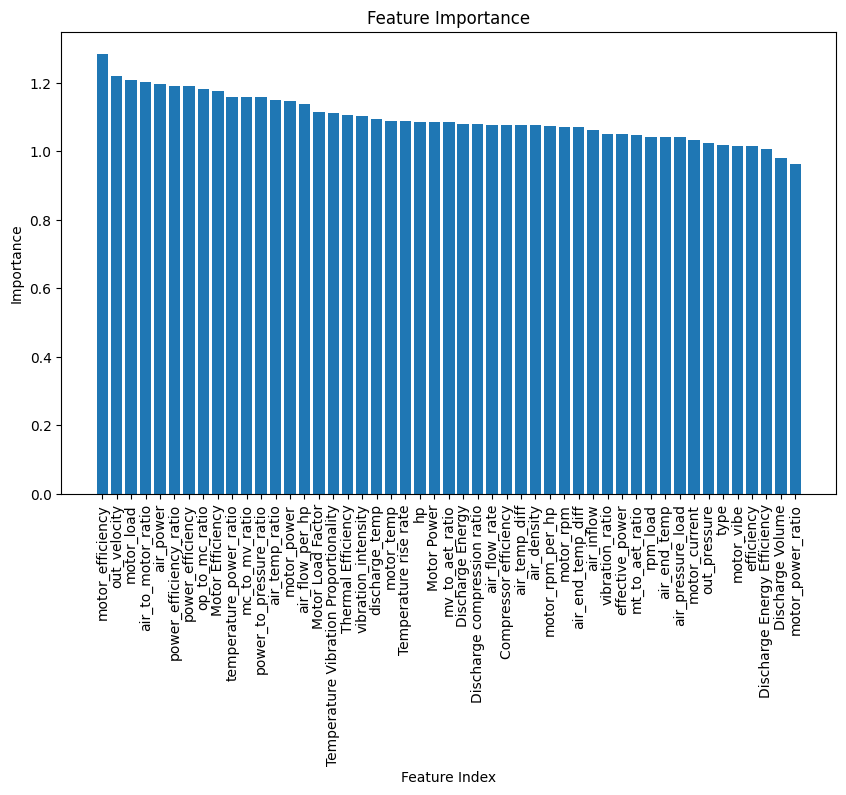

In [ ]:
import matplotlib.pyplot as plt

columns = train_data.columns

# Extract encoder layer and weights
encoder_layer = autoencoder.layers[0]
weights = encoder_layer.get_weights()[0]

# Calculate feature importance as the L2 norm of weights
feature_importance = np.linalg.norm(weights, axis=1)

# Sort feature importance in descending order
sorted_importance_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_importance_indices]

# Create bar chart of sorted feature importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_importance)), sorted_importance)
ax.set_title('Feature Importance')
ax.set_xlabel('Feature Index')
ax.set_ylabel('Importance')
ax.set_xticks(range(len(sorted_importance)))
ax.set_xticklabels(columns[sorted_importance_indices])
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Extract encoder layer and weights
encoder_layer = autoencoder.layers[0]
weights = encoder_layer.get_weights()[0]

# Calculate feature importance as the L2 norm of weights
feature_importance = np.linalg.norm(weights, axis=1)

# Sort feature importance in descending order
sorted_importance_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_importance_indices]

# Print sorted feature importance
for i in range(len(sorted_importance)):
    print('{}: {:.2f}'.format(columns[sorted_importance_indices[i]], sorted_importance[i]))

motor_efficiency: 1.29
out_velocity: 1.22
motor_load: 1.21
air_to_motor_ratio: 1.20
air_power: 1.20
power_efficiency_ratio: 1.19
power_efficiency: 1.19
op_to_mc_ratio: 1.18
Motor Efficiency: 1.18
temperature_power_ratio: 1.16
mc_to_mv_ratio: 1.16
power_to_pressure_ratio: 1.16
air_temp_ratio: 1.15
motor_power: 1.15
air_flow_per_hp: 1.14
Motor Load Factor: 1.12
Temperature Vibration Proportionality: 1.11
Thermal Efficiency: 1.11
vibration_intensity: 1.10
discharge_temp: 1.10
motor_temp: 1.09
Temperature rise rate: 1.09
hp: 1.09
Motor Power: 1.09
mv_to_aet_ratio: 1.08
Discharge Energy: 1.08
Discharge compression ratio: 1.08
air_flow_rate: 1.08
Compressor efficiency: 1.08
air_temp_diff: 1.08
air_density: 1.08
motor_rpm_per_hp: 1.07
motor_rpm: 1.07
air_end_temp_diff: 1.07
air_inflow: 1.06
vibration_ratio: 1.05
effective_power: 1.05
mt_to_aet_ratio: 1.05
rpm_load: 1.04
air_end_temp: 1.04
air_pressure_load: 1.04
motor_current: 1.03
out_pressure: 1.03
type: 1.02
motor_vibe: 1.02
efficiency: 1.

In [ ]:
# Calculate the reconstruction error for test_data
test_data_reconstructed = autoencoder.predict(test_data_scaled)
reconstruction_error = np.mean(np.square(test_data_scaled - test_data_reconstructed), axis=1)

# Set a threshold for considering a test point as an anomaly
threshold = np.percentile(reconstruction_error, 95.39)

# Predict anomalies in test_data
prediction = (reconstruction_error > threshold).astype(int)

# If you have the ground truth labels for the test_data, you can compute the F1 score:
# test_true_labels = ...
# f1 = f1_score(test_true_labels, test_predictions)
# print("F1 score:", f1)

231/231 [==============================] - 0s 1ms/step


In [ ]:
prediction

array([0, 0, 0, ..., 0, 0, 0])

### 기본_optuna 적용
* 하이퍼 파라미터 튜닝

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.8 MB/s eta 0:00:00


In [ ]:
import optuna
from tensorflow.keras import layers, models

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the autoencoder architecture
def create_model(trial):
    activation = trial.suggest_categorical('activation', ['relu', 'elu', 'swish'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    input_dim = train_data_scaled.shape[1]
    encoding_dim = trial.suggest_int('encoding_dim', 16, 256)
    hidden_dim = trial.suggest_int('hidden_dim', 8, 128)

    encoder = tf.keras.Sequential([
        tf.keras.layers.Dense(encoding_dim, activation=activation, input_shape=(input_dim,)),
        tf.keras.layers.Dense(hidden_dim, activation=activation)
    ])

    decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(encoding_dim, activation=activation, input_shape=(hidden_dim,)),
        tf.keras.layers.Dense(input_dim, activation='linear')
    ])

    autoencoder = tf.keras.Sequential([encoder, decoder])

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return autoencoder

# Define the Objective function for Optuna
def objective(trial):
    autoencoder = create_model(trial)
    
    # Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    autoencoder.fit(train_data_scaled, train_data_scaled, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)
    
    # Calculate the reconstruction error for test_data
    test_data_reconstructed = autoencoder.predict(test_data_scaled)
    reconstruction_error = np.mean(np.square(test_data_scaled - test_data_reconstructed), axis=1)

    # Set a threshold for considering a test point as an anomaly
    threshold = np.percentile(reconstruction_error, 95)

    # Predict anomalies in test_data
    prediction = (reconstruction_error > threshold).astype(int)

    # Calculate the MSE as the performance metric
    mse = mean_squared_error(test_data_scaled, test_data_reconstructed)
    return mse

# Use Optuna to optimize the Objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters found by Optuna
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Train the model with the best hyperparameters
best_autoencoder = create_model(best_params)
best_autoencoder.fit(train_data_scaled, train_data_scaled, 
                     epochs=500, batch_size=32, 
                     validation_split=0.1, 
                     callbacks=[early_stopping], verbose=1)

# Calculate the reconstruction error for test_data
test_data_reconstructed = best_autoencoder.predict(test_data_scaled)
reconstruction_error = np.mean(np.square(test_data_scaled - test_data_reconstructed), axis=1)

# Set a threshold for considering a test point as an anomaly
threshold = np.percentile(reconstruction_error, 95)

# Predict anomalies in test_data
prediction = (reconstruction_error > threshold).astype(int)

# # Calculate F1 score for anomaly detection
# f1 = f1_score(test_labels, prediction)
# print(f"F1 score: {f1}")

## Adversarial AutoEncoder

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the autoencoder architecture
input_dim = train_data_scaled.shape[1]
encoding_dim = 17
hidden_dim = 75

# Define the Discriminator architecture
discriminator = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim * 2,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Define the Encoder and Decoder architecture
encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dense(hidden_dim, activation='relu')
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(hidden_dim,)),
    tf.keras.layers.Dense(input_dim, activation='linear')
])

# Define the Adversarial Autoencoder
input_data = tf.keras.layers.Input(shape=(input_dim,))
encoded = encoder(input_data)
decoded = decoder(encoded)
ae_output = tf.keras.layers.Concatenate()([input_data, decoded])

discriminator.trainable = False
discriminator_output = discriminator(ae_output)

aae = tf.keras.Model(inputs=input_data, outputs=[decoded, discriminator_output])

# Compile and train the Adversarial Autoencoder with early stopping
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
aae.compile(loss=['mse', 'binary_crossentropy'], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
aae.fit(train_data_scaled, [train_data_scaled, np.ones((train_data_scaled.shape[0], 1))], epochs=500, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

In [ ]:
# Get the reconstructed test data from the Adversarial Autoencoder
test_data_reconstructed, _ = aae.predict(test_data_scaled)

# Calculate the reconstruction error
reconstruction_error = np.mean(np.square(test_data_scaled - test_data_reconstructed), axis=1)

# Obtain the predicted labels for the test data
# threshold = np.mean(reconstruction_error) + np.std(reconstruction_error)
threshold = np.percentile(reconstruction_error, 97)
prediction = (reconstruction_error > threshold).astype(np.int32)

print(np.mean(reconstruction_error) + np.std(reconstruction_error))


231/231 [==============================] - 0s 2ms/step
0.5941492851930237


## AutoEncoder

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense
from keras.models import Model

# 데이터 전처리
scaler = StandardScaler()
train_data_scaler = scaler.fit_transform(train_data)
test_data_scaler = scaler.transform(test_data)

# AutoEncoder 모델 구현
input_dim = train_data.shape[1]
encoding_dim = 15  # encoding 차원 수
input_layer = Input(shape=(input_dim,))
encoder_layer = Dense(encoding_dim, activation='relu')(input_layer)
decoder_layer = Dense(input_dim, activation='sigmoid')(encoder_layer)
autoencoder = Model(input_layer, decoder_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# 학습 데이터에서 모델 학습
autoencoder.fit(train_data_scaler, train_data_scaler, epochs=50, batch_size=32, validation_split=0.2)

# 테스트 데이터에서 이상 탐지
test_predictions = autoencoder.predict(test_data_scaler)
mse = np.mean(np.power(test_data_scaler - test_predictions, 2), axis=1)
# threshold = np.max(mse)  # 이상 탐지 경계값 설정
test_labels = (mse > 95).astype(int)  # 이상 여부 판별

# 결과 출력
print(test_labels)

Epoch 1/50
62/62 [==============================] - 1s 4ms/step - loss: 1.2203 - val_loss: 0.6017
Epoch 2/50
62/62 [==============================] - 0s 3ms/step - loss: 0.9657 - val_loss: 0.4690
Epoch 3/50
62/62 [==============================] - 0s 3ms/step - loss: 0.7903 - val_loss: 0.4005
Epoch 4/50
62/62 [==============================] - 0s 3ms/step - loss: 0.7227 - val_loss: 0.3723
Epoch 5/50
62/62 [==============================] - 0s 3ms/step - loss: 0.6944 - val_loss: 0.3572
Epoch 6/50
62/62 [==============================] - 0s 3ms/step - loss: 0.6798 - val_loss: 0.3476
Epoch 7/50
62/62 [==============================] - 0s 3ms/step - loss: 0.6706 - val_loss: 0.3397
Epoch 8/50
62/62 [==============================] - 0s 3ms/step - loss: 0.6638 - val_loss: 0.3332
Epoch 9/50
62/62 [==============================] - 0s 3ms/step - loss: 0.6586 - val_loss: 0.3273
Epoch 10/50
62/62 [==============================] - 0s 3ms/step - loss: 0.6546 - val_loss: 0.3223
Epoch 11/50
62/62 [

# 데이터 저장

In [ ]:
from collections import Counter

# Count the number of 0s and 1s in y_pred_binary
count = Counter(prediction)
num_0 = count[0]
num_1 = count[1]

print("Number of 0s: ", num_0)
print("Number of 1s: ", num_1)
#이상치 평균 5퍼센트

Number of 0s:  7048
Number of 1s:  341


In [ ]:
test_data.shape

(7389, 49)

In [ ]:
file_name = 'ae_49features_th9539'

In [ ]:
idx = test_data.loc[:, 'type']
y_pred = {'type': idx, 'label': prediction}
test_predictions_basic_epoch500_pt5 = pd.DataFrame(y_pred)
test_predictions_basic_epoch500_pt5.to_csv(f"/content/drive/MyDrive/AIFactory/dataset/{file_name}.csv")

In [ ]:
idx = test_data.loc[:, 'type']
y_pred = {'type': idx, 'label': prediction}
test_predictions_basic_epoch500_pt5 = pd.DataFrame(y_pred)
test_predictions_basic_epoch500_pt5.to_csv(f"{file_name}.csv")